In [6]:
import numpy as np
import pandas as pd
import os
import torch
import pingouin as pg
from tqdm import tqdm
from nilearn import datasets
from nilearn import plotting
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import nibabel as nb
from scipy.stats import pearsonr, spearmanr
from scipy.spatial.distance import correlation
from torch.utils.data import DataLoader, Dataset, Subset
from nilearn.connectome import sym_matrix_to_vec
from sklearn.manifold import TSNE
from ContModeling.helper_classes import MatData
from ContModeling.models import PhenoProj
from hydra import initialize, compose
from omegaconf import DictConfig, OmegaConf
import xarray as xr
from neuromaps.datasets import fetch_fslr, fetch_fsaverage
from brainspace.utils.parcellation import map_to_labels, reduce_by_labels
from brainspace.datasets import load_conte69, load_parcellation
from brainspace.plotting import plot_hemispheres
from surfplot import Plot
import nilearn as nl
import cmasher as cmr
from statsmodels.robust.scale import Huber
from ContModeling.viz_func import replace_with_network


In [7]:
mpl.rcParams['svg.fonttype'] = 'none'

In [8]:
def custom_corr(y, y_pred):
    corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)
    return corr

In [9]:
def get_network_indices(network_labels):
    network_indices = dict.fromkeys(network_labels)
    network_labels = np.array(network_labels)
    for key in network_indices.keys():
        network_indices[key] = np.arange(len(network_labels))[network_labels == key]
    return network_indices

In [18]:
dataset_name = "hcp"
domain = "cog"


In [19]:
if dataset_name == "hcp":
    surfaces = fetch_fslr()
    lh, rh = surfaces['midthickness']
    n_vrtx_hemi = 32492
elif dataset_name == "abcd":
    surfaces = fetch_fsaverage()
    lh, rh = surfaces['white']
    n_vrtx_hemi = 40962

In [20]:
dataset_path = f"data/{dataset_name}_400parcels.nc"
dataset = xr.open_dataset(dataset_path)

In [21]:
mode = "shuffle"
with initialize(version_base=None, config_path="."):
    cfg = compose(config_name=f'{mode}_main_model_config.yaml')
    print(OmegaConf.to_yaml(cfg))

project: ABCD_SHUFFLE_REDMAT_DEC_MULTIVAR_COG
experiment_name: shuffle_redmat_dec_abcd_multivar_cog
hypothesis: '-'
input_dim_feat: 400
output_dim_feat: 100
hidden_dim: 128
input_dim_target: 10
output_dim_target: 64
random_seed:
- 1001
- 42
- 54
- 90
- 101
- 80
- 422
- 142
- 128
- 340
skip_conn: false
skip_enc1: false
ReEig: false
full_model_pretrained: true
mat_ae_pretrained: false
reduced_mat_ae_pretrained: false
mat_ae_pretrained_exp: shuffle_pretrain_mat_ae_abcd
pretrained_reduced_mat_ae_exp: ext_sup_reduced_mat_ae_abcd
full_model_pretrained_exp: shuffle_redmat_enc_abcd_multivar_cog
mat_ae_enc_freeze: true
mat_ae_dec_freeze: true
reduced_mat_ae_enc_freeze: true
reduced_mat_ae_dec_freeze: false
target_dec_freeze: true
best_mat_ae_fold: 2
best_reduced_mat_ae_fold: 4
synth_exp: false
multi_gpu: true
num_epochs: 500
batch_size: 256
n_runs: 1
lr: 0.001
weight_decay: 0.0001
dropout_rate: 0
scheduler_patience: 20
test_ratio: 0.3
train_ratio:
- 1.0
log_gradients: true
clip_grad: true
netwo

In [22]:
data_path = cfg.dataset.dataset_path
results_path = './results'

In [23]:
# fig_dir = os.path.join(results_path, f"{mode}_redmat_dec_abcd_multivar_{domain}_only", 'figures')
fig_dir = f"./figures/{dataset_name}_{mode}_{domain}"
os.makedirs(fig_dir, exist_ok=True)

### Matrix Reconstruction

In [24]:
mode = "shuffle"

train_ratio = 1.0
exp_name = f"{mode}_redmat_dec_{dataset_name}_multivar_{domain}"
exp_dir = f'./results/{exp_name}'
recon_dir = f'{exp_dir}/recon_mat'

In [25]:
exp_name

'shuffle_redmat_dec_hcp_multivar_cog'

In [26]:
if mode == 'shuffle':
    n_runs = cfg.random_seed
    run_type = "seed"
    test_type = "test"
else:
    n_runs = np.arange(cfg.kfolds)
    run_type = "fold"
    test_type = "validation"

In [28]:
test_idx = np.concatenate([np.load(f'{exp_dir}/{test_type}_idx_{run_type}{run}_train_ratio{train_ratio}.npy') for run in n_runs])
recon_mat = np.concatenate([np.load(f'{recon_dir}/pca_recon_mat_{run_type}{run}_train_ratio{train_ratio}.npy') for run in n_runs], axis = 0)
mape_mat = np.concatenate([np.load(f'{recon_dir}/pca_mape_mat_{run_type}{run}_train_ratio{train_ratio}.npy') for run in n_runs], axis = 0)
true_mat = np.stack([dataset.matrices.isel(index = idx).values for idx in test_idx])

In [15]:
subj_atlas = np.array([np.concatenate([dataset.isel(index=idx).parc_lh.values, dataset.isel(index=idx).parc_rh.values]) for idx in test_idx])

In [29]:
def compute_batch_elementwise_correlation(true, recon):
    batch_size, rows, cols = true.shape
    correlations = np.zeros((rows, cols))

    flat_true = true.reshape(batch_size, -1)
    flat_recon = recon.reshape(batch_size, -1)
    
    for i in range(rows * cols):
        correlations[i // cols, i % cols] = spearmanr(flat_true[:, i], flat_recon[:, i])[0]
        
    np.fill_diagonal(correlations, 1.0)

    return correlations

In [30]:
def sort_corrs_by_network(mat_corr, network_labels, threshold=0, corr=True):

    discard_ones_mat = mat_corr.copy()

    if corr:
        discard_ones_mat = mat_corr.copy()
        np.fill_diagonal(discard_ones_mat, 0)
    
    if threshold:
        if corr:
            perc = np.percentile(discard_ones_mat, threshold)
            discard_ones_mat[discard_ones_mat < perc] = np.nan
        else:
            perc = -np.percentile(-discard_ones_mat, threshold)
            discard_ones_mat[discard_ones_mat > perc] = np.nan
    
    if corr:
        measure_name = "Correlation"
    else:
        measure_name = "MAPE"

    corr_data = {
        measure_name: [],
        'Network': []
    }

    for i, network in enumerate(np.unique(network_labels)):
        network_indices = [i for i, label in enumerate(network_labels) if label == network]
        subset_network = discard_ones_mat[network_indices].flatten()
        subset_network = subset_network[~np.isnan(subset_network)]
        corr_data[measure_name].extend(subset_network)
        corr_data['Network'].extend(len(subset_network) * [network])
        
    corr_data = pd.DataFrame(corr_data)
    if corr:
        corr_data = corr_data[corr_data['Correlation'] != 0]

    return corr_data

In [18]:
# def sort_corrs_by_network(mat_corr, network_labels):
#     corr_data = {
#         'Correlation': [],
#         'Network': []
#     }
#     for i, network in enumerate(network_labels):
#         corr_data['Correlation'].extend([mat_corr[i, i]])
#         corr_data['Network'].extend([network])
        
#     corr_data = pd.DataFrame(corr_data)

#     return corr_data

In [31]:
atlas_7labels = datasets.fetch_atlas_schaefer_2018()['labels']
atlas_17labels = pd.read_csv(f'./data/parcellations/Schaefer2018_400Parcels_Kong2022_17Networks_order_info.txt', dtype=str, header=None).to_numpy().T[0][::2]

atlas_7labels = [label.decode('utf-8') for label in atlas_7labels]

network7_labels = ['Vis',
                'SomMot',
                'DorsAttn',
                'SalVentAttn',
                'Limbic',
                'Cont',
                'Default'
]

network17_labels = {
                    'DefaultA':1,
                    'DefaultB':2,
                    'DefaultC':3,
                    'Language':4,
                    'ContA':5,
                    'ContB':6,
                    'ContC':7,
                    'SalVenAttnA':8,
                    'SalVenAttnB':9,
                    'DorsAttnA':10,
                    'DorsAttnB':11,
                    'Aud':12,
                    'SomMotA':13,
                    'SomMotB':14,
                    'VisualA':15,
                    'VisualB':16,
                    'VisualC':17,
}

network7_labels = [replace_with_network(label, network7_labels) for label in atlas_7labels]
network17_str_labels = [replace_with_network(label, list(network17_labels.keys())) for label in atlas_17labels]
# network17_scalar_labels = []

network7_indices = get_network_indices(network7_labels)
network17_indices = get_network_indices(network17_str_labels)

yeo7_colors ={
    'Vis': '#761984',
    'SomMot':'#4679a4',
    'DorsAttn':'#0a7316',
    'SalVentAttn':'#ba3eec',
    'Limbic':'#92ab67',
    'Cont':'#d78e27',
    'Default':'#c4414f'
}

yeo17_colors ={
    'DefaultA': '#ffff00',
    'DefaultB': '#cd3e4e',
    'DefaultC': '#000082',
    'Language': '#0c30ff',
    'ContA': '#e69422',
    'ContB': '#87324a',
    'ContC': '#778cb0',
    'SalVenAttnA': '#c43afa',
    'SalVenAttnB': '#ff98d5',
    'DorsAttnA': '#4a9b3c',
    'DorsAttnB': '#00760e',
    'Aud': '#dcf8a4',
    'SomMotA': '#4682b4',
    'SomMotB': '#2acca4',
    'VisualA': '#781286',
    'VisualB': '#ff0000',
    'VisualC': '#7a8732',
}

network7_colors = [yeo7_colors[network] for network in network7_labels]
network17_colors = [yeo17_colors[network] for network in network17_str_labels]


[get_dataset_dir] Dataset found in /Users/VictoriaShevchenko/nilearn_data/schaefer_2018


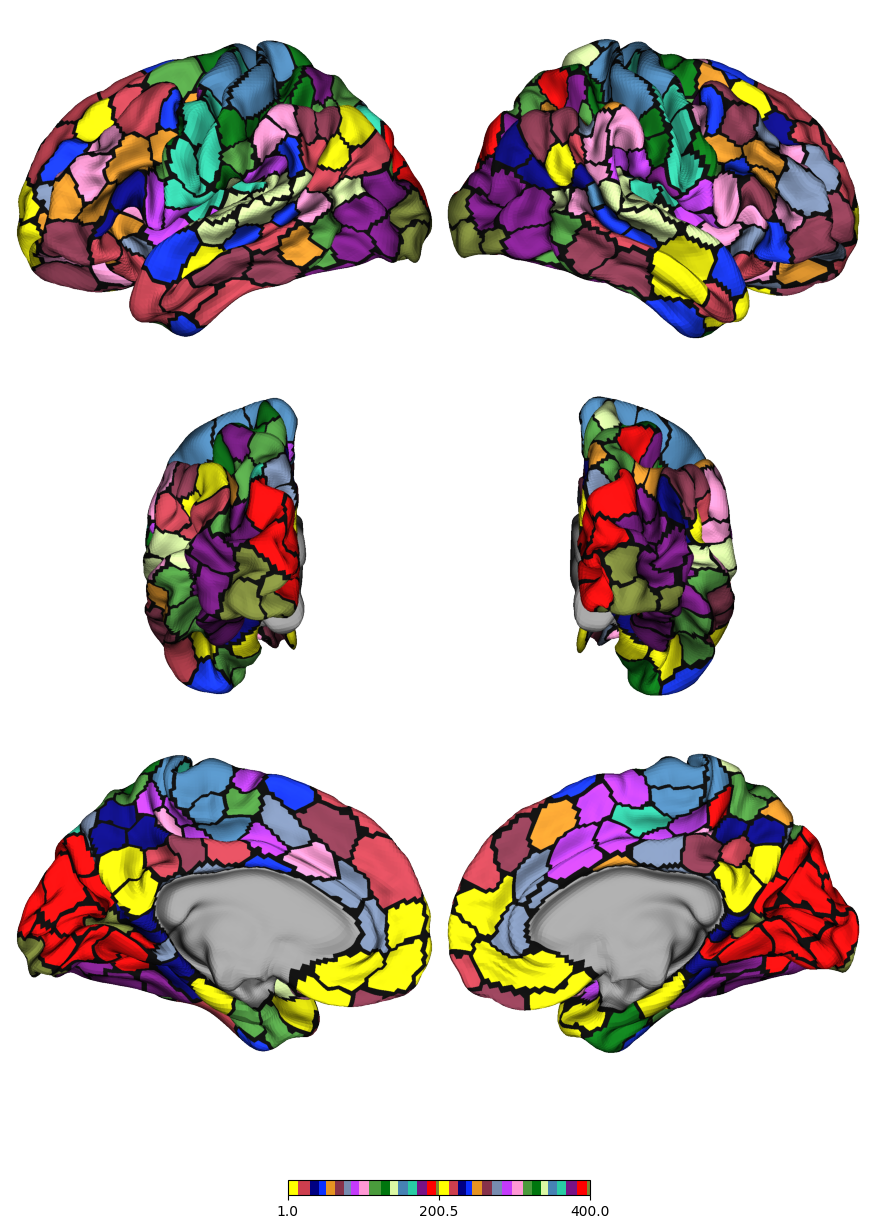

In [ ]:
from matplotlib.colors import ListedColormap

atlas_lh = nb.load("./data/parcellations/Schaefer2018_400Parcels_Kong2022_17Networks_order.dscalar.nii").get_fdata()[0][:32492]
atlas_rh = nb.load("./data/parcellations/Schaefer2018_400Parcels_Kong2022_17Networks_order.dscalar.nii").get_fdata()[0][32492:]

cmap= ListedColormap(network17_colors)

surf_parc_lh, surf_parc_rh = fetch_fslr()["midthickness"]
mape_plot = Plot(surf_parc_lh, surf_parc_rh,
                 size=(1200, 1500),
                 brightness=0.5,
                 views=['lateral', 'posterior', 'medial'])
mape_plot.add_layer({'left': atlas_lh,
                     'right': atlas_rh},
                     cbar=True, cmap=cmap, 
                     zero_transparent=True,
                     alpha=1
)
mape_plot.add_layer({'left': atlas_lh,
                     'right': atlas_rh},
                     cmap='gray',
                     as_outline=True,
                     cbar=False
)


fig = mape_plot.build()
# fig.axes[0].set_title('Mean MAPE Across Edges: True Conn vs. Recon', pad=-3)
fig.savefig(f"./figures/kong2022_networks_parc.svg", format = "svg", dpi = 300, bbox_inches='tight')

In [32]:
recon_corr_mat = compute_batch_elementwise_correlation(true_mat, recon_mat)

/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_676/4045408121.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlations[i // cols, i % cols] = spearmanr(flat_true[:, i], flat_recon[:, i])[0]


In [33]:
np.save(f'{fig_dir}/pca_recon_corr_mat_{dataset_name}_{domain}.npy', recon_corr_mat)

In [160]:
recon_corr_mat = np.load(f'{fig_dir}/recon_corr_mat_{dataset_name}_{domain}.npy')

In [131]:
f'{fig_dir}/recon_corr_mat_{dataset_name}_{domain}.npy'

'./figures/abcd_shuffle_cog/recon_corr_mat_abcd_cog.npy'

In [161]:
recon_corr_by_17networks = sort_corrs_by_network(recon_corr_mat, network17_str_labels, threshold=0, corr=True)

In [168]:
sns.set_style("whitegrid")

mean_corr_net = recon_corr_by_17networks.groupby('Network')['Correlation'].median()
sorted_networks = mean_corr_net.sort_values(ascending=False).index
recon_corr_by_17networks['Network Sorted'] = pd.Categorical(recon_corr_by_17networks['Network'], categories=sorted_networks)

f, ax = plt.subplots(figsize=(20, 3))
ax=pt.RainCloud(x="Network Sorted", y = "Correlation", data=recon_corr_by_17networks, palette = yeo17_colors,
                 width_viol = 0.7, width_box=0.2, skip_stripplot=True, ax = ax, point_size = 0.1,
                 linewidth=1)

plt.xticks(rotation=45)
ax.axhline(0, color='red', linestyle='--', linewidth=2)

# plt.ylim(-.05, 1.05)
# plt.legend(title='Agg Measure: All wrt Centroid', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.xlabel('Value')
# plt.xlabel('Agg Measure: All wrt Centroid')
plt.title(f"Correlations by network, 17 Networks (Kong 2021), Dataset: {dataset_name}, Domain: {domain}")
plt.savefig(f'{fig_dir}/recon_corr_by_17networks_{dataset_name}_{domain}.svg', format = "svg", dpi = 300, bbox_inches='tight')

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


In [36]:
from matplotlib.patches import Rectangle

f, ax = plt.subplots(figsize = (10, 10))
im = ax.imshow(recon_corr_mat, cmap='seismic', vmin=-1, vmax=1)
# axes[1].set_title(f'Cluster {cluster}: Matrix closest to the centroid')
cbar = f.colorbar(im, ax=ax, shrink=0.8)  # Adjust `shrink` to control the size of the colorbar
cbar.set_label("Correlation", fontsize=12)
plt.text(0.4, 0.02, f'Median r = {np.median(recon_corr_mat):.2f}', color='black', ha='right', va='bottom', fontsize=20, transform=plt.gca().transAxes,
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

ax.set_xticks([])
ax.set_yticks([])
for i, color in enumerate(network17_colors):
    ax.add_patch(Rectangle((-0.5, i - 0.5)
    , -10, 1, color=color, clip_on=False))
    ax.add_patch(Rectangle((i - 0.5, -0.7), 1, -10, color=color, clip_on=False))

# plt.savefig(f"{fig_dir}/corr_true_recon_{dataset_name}_{domain}.svg", format = "svg", dpi = 300, bbox_inches='tight')

### Subject Example

In [5]:
# from matplotlib.patches import Rectangle
# data = xr.open_dataset("./data/hcp_400parcels.nc").matrices.values[10]
# f, ax = plt.subplots(figsize = (10, 10))
# im = ax.imshow(data, cmap='seismic', vmin=-1, vmax=1)
# # axes[1].set_title(f'Cluster {cluster}: Matrix closest to the centroid')
# cbar = f.colorbar(im, ax=ax, shrink=0.8)  # Adjust `shrink` to control the size of the colorbar
# cbar.set_label("Correlation", fontsize=20)


# ax.set_xticks([])
# ax.set_yticks([])
# for i, color in enumerate(network17_colors):
#     ax.add_patch(Rectangle((-0.5, i - 0.5)
#     , -10, 1, color=color, clip_on=False))
#     ax.add_patch(Rectangle((i - 0.5, -0.7), 1, -10, color=color, clip_on=False))

# plt.savefig(f"./figures/sub_example.svg", format = "svg", dpi = 300, bbox_inches='tight')


In [34]:
huber_estimator = Huber(maxiter=1000)

In [35]:
robust_mean_mape_mat = np.empty((400, 400))
for i in range(400):
    for j in range(400):
        robust_mean_mape_mat[i, j], _ = huber_estimator(mape_mat[:, i, j], initscale=np.array(1000))

np.save(f'{fig_dir}/pca_robust_mean_mape_mat_{dataset_name}_{domain}.npy', robust_mean_mape_mat)

In [95]:
f'{fig_dir}/robust_mean_mape_mat_{dataset_name}_{domain}.npy'

'./figures/hcp_shuffle_psy/robust_mean_mape_mat_hcp_psy.npy'

In [164]:
robust_mean_mape_mat = np.load(f'{fig_dir}/robust_mean_mape_mat_{dataset_name}_{domain}.npy')

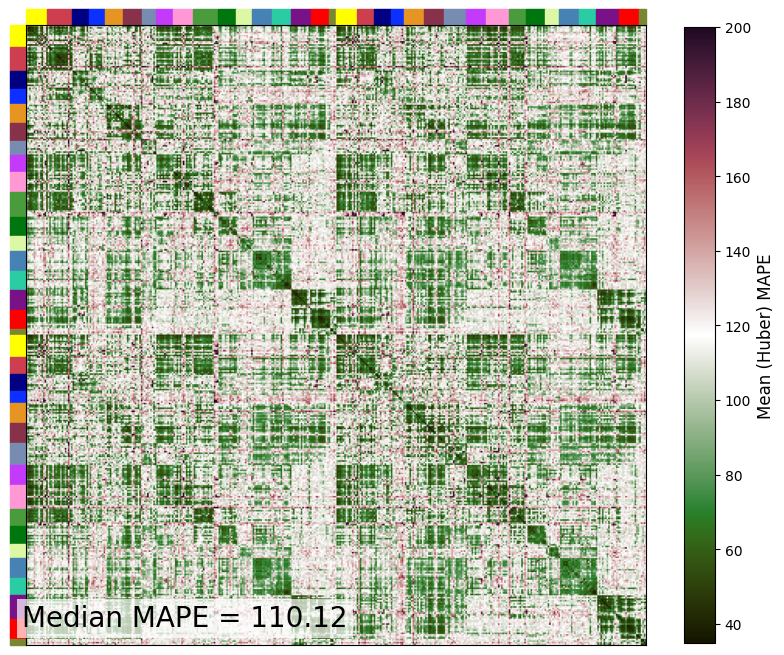

In [38]:
from matplotlib.patches import Rectangle

f, ax = plt.subplots(figsize = (10, 10))
im = ax.imshow(robust_mean_mape_mat, cmap='cmr.holly', vmax=200)
# axes[1].set_title(f'Cluster {cluster}: Matrix closest to the centroid')
cbar = f.colorbar(im, ax=ax, shrink=0.8)  # Adjust `shrink` to control the size of the colorbar
cbar.set_label("Mean (Huber) MAPE", fontsize=12)
plt.text(0.52, 0.02, f'Median MAPE = {np.median(robust_mean_mape_mat):.2f}', color='black', ha='right', va='bottom', fontsize=20, transform=plt.gca().transAxes,
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

ax.set_xticks([])
ax.set_yticks([])
for i, color in enumerate(network17_colors):
    ax.add_patch(Rectangle((-0.5, i - 0.5), -10, 1, color=color, clip_on=False))
    ax.add_patch(Rectangle((i - 0.5, -0.7), 1, -10, color=color, clip_on=False))

# plt.savefig(f"{fig_dir}/robust_mean_mape_mat_{dataset_name}_{domain}.svg", format = "svg", dpi = 300, bbox_inches='tight')

In [165]:
mape_by_17networks = sort_corrs_by_network(robust_mean_mape_mat, network17_str_labels, threshold=0, corr=False)

In [167]:
import ptitprince as pt
sns.set_style("whitegrid")
mean_mape_net = mape_by_17networks.groupby('Network')['MAPE'].mean()
sorted_networks = mean_mape_net.sort_values(ascending=True).index
mape_by_17networks['Network Sorted'] = pd.Categorical(mape_by_17networks['Network'], categories=sorted_networks)

f, ax = plt.subplots(figsize=(20, 3))

ax=pt.RainCloud(x="Network Sorted", y = "MAPE", data=mape_by_17networks, palette = yeo17_colors,
                 width_viol = 0.65, width_box=0.2, skip_stripplot=True, ax = ax, point_size = 0.1,
                 linewidth=1)


# horizontal line at 100
ax.axhline(100, color='red', linestyle='--', linewidth=2)
plt.ylim(0, 200)
plt.xticks(rotation=45)
plt.ylabel('MAPE')

plt.title(f"MAPE by network, 17 Networks (Kong 2021), Dataset: {dataset_name}, Domain:{domain}")
plt.savefig(f'{fig_dir}/mape_by_17networks_{dataset_name}_{domain}.svg', format = "svg", dpi = 300, bbox_inches='tight')

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


In [2]:
df

Network  MAPE
0       ContB    80
1    DefaultB    75
2       ContB    90
3    DefaultB    85
4       ContB    80
..        ...   ...
195  DefaultB    85
196     ContB    80
197  DefaultB    75
198     ContB    90
199  DefaultB    85

[200 rows x 2 columns]

### Plotting on Surfaces

In [47]:
if dataset_name == "hcp":
    schaefer17_labels = nb.load("./data/parcellations/Schaefer2018_400Parcels_Kong2022_17Networks_order.dscalar.nii").get_fdata()[0]
else:
    lh_annot = nb.freesurfer.read_annot("./data/parcellations/lh.Schaefer2018_400Parcels_17Networks_order.annot")[0].astype(float)
    rh_annot = nb.freesurfer.read_annot("./data/parcellations/rh.Schaefer2018_400Parcels_17Networks_order.annot")[0].astype(float)
    not0_annot_mask = np.where(rh_annot != 0)[0]
    rh_annot[not0_annot_mask] = rh_annot[not0_annot_mask] + 200
    schaefer17_labels = np.concatenate([lh_annot, rh_annot]).astype(float)

In [204]:
robust_mean_mape_mat = np.load(f'{fig_dir}/robust_mean_mape_mat_{dataset_name}_{domain}.npy')

In [ ]:
group_region_mape_mean = np.mean(robust_mean_mape_mat.copy(), axis = 0)
top_20percent = -np.nanpercentile(-group_region_mape_mean, 80)


/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


In [142]:
robust_mean_mape_mat = np.load(f'{fig_dir}/robust_mean_mape_mat_{dataset_name}_{domain}.npy')
top_20percent = -np.nanpercentile(-robust_mean_mape_mat, 0)
robust_mean_mape_mat[robust_mean_mape_mat > top_20percent] = np.nan
group_region_mape_mean = np.nanmean(robust_mean_mape_mat, axis = 0)
# group_region_mape_mean[np.where(np.isnan(group_region_mape_mean))] = 200

In [144]:
plt.imshow(robust_mean_mape_mat)

In [145]:
group_region_mape_mean_mapped = map_to_labels(group_region_mape_mean, schaefer17_labels, mask=schaefer17_labels != 0, fill=np.nan)

In [124]:
np.nanmin(group_region_mape_mean)


29.745221903681646

In [146]:
cmap = plt.get_cmap('cmr.swamp')

mape_plot = Plot(lh, rh, size=(1200, 1500), brightness=0.5, views=['lateral', 'posterior', 'medial'])
mape_plot.add_layer({'left': group_region_mape_mean_mapped[:n_vrtx_hemi],
                     'right': group_region_mape_mean_mapped[n_vrtx_hemi:]},
                     cbar=True, cmap=cmap, 
                    #  color_range=(29, 40),
                     zero_transparent=True,
                     alpha=1
)

fig = mape_plot.build()
fig.axes[0].set_title('Mean MAPE Across Edges: True Conn vs. Recon', pad=-3)
# fig.savefig(f"{fig_dir}/mape_labeled_{dataset_name}_{domain}.svg", format = "svg", dpi = 300, bbox_inches='tight')

Text(0.5, 1.0, 'Mean MAPE Across Edges: True Conn vs. Recon')

In [208]:
recon_corr_mat = np.load(f'{fig_dir}/recon_corr_mat_{dataset_name}_{domain}.npy')

In [209]:
copy_recon_corr_mat = recon_corr_mat.copy()
np.fill_diagonal(copy_recon_corr_mat, 0)
group_region_corr_mean = np.mean(copy_recon_corr_mat, axis = 0)
top_20percent = np.nanpercentile(group_region_corr_mean, 80)


In [210]:
group_region_corr_mean_mapped = map_to_labels(group_region_corr_mean, schaefer17_labels, mask=schaefer17_labels != 0, fill=np.nan)

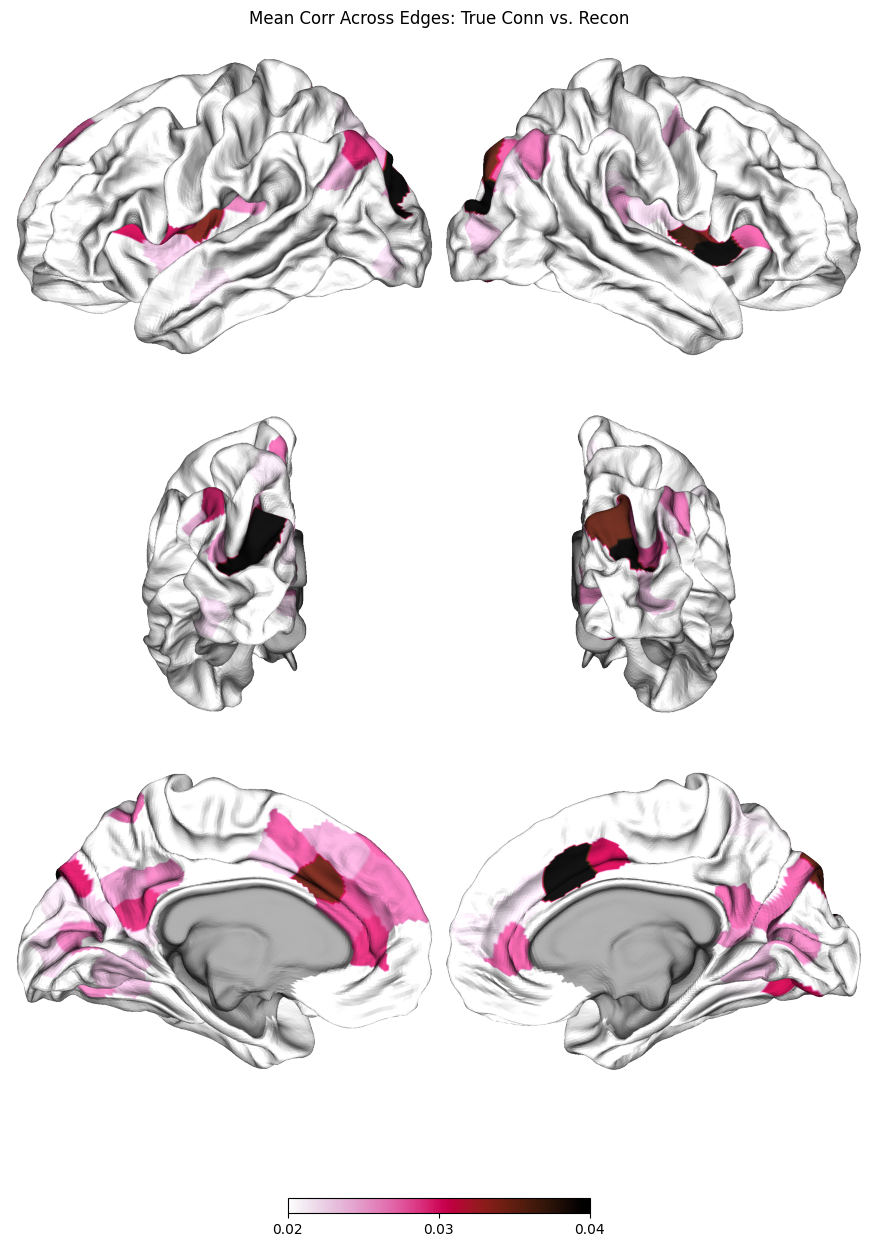

In [211]:
cmap = plt.get_cmap('cmr.flamingo_r')

mape_plot = Plot(lh, rh, size=(1200, 1500), brightness=0.5, views=['lateral', 'posterior', 'medial'])
mape_plot.add_layer({'left': group_region_corr_mean_mapped[:n_vrtx_hemi],
                     'right': group_region_corr_mean_mapped[n_vrtx_hemi:]},
                     cbar=True, cmap=cmap, 
                     color_range=(top_20percent, 0.04),
                     zero_transparent=True,
                     alpha=1
)

fig = mape_plot.build()
fig.axes[0].set_title('Mean Corr Across Edges: True Conn vs. Recon', pad=-3)
fig.savefig(f"{fig_dir}/recon_corr_labeled_{dataset_name}_{domain}.svg", format = "svg", dpi = 300, bbox_inches='tight')

### Mapping group trend separately for ABCD subjects just in case

In [95]:
group_mape_mapped = []

for order_idx, idx in enumerate(test_idx):
    atlas_labels = subj_atlas[idx]
    group_mape_subj_level = map_to_labels(np.mean(robust_mean_mape_mat, axis = 0), atlas_labels, mask=atlas_labels != 0, fill=np.nan)
    group_mape_mapped.append(group_mape_subj_level)
group_mape_mapped = np.array(group_mape_mapped)

In [94]:
recon_corr_mat = np.load(f'{fig_dir}/recon_corr_mat_{dataset_name}_{domain}.npy')


In [320]:
group_corr_mapped_mean = np.mean(recon_corr_mat, axis = 0)
top_20percent = np.nanpercentile(group_corr_mapped_mean, 80)


In [321]:
group_corr_mapped_mean_mapped = map_to_labels(group_corr_mapped_mean, schaefer17_labels, mask=schaefer17_labels != 0, fill=np.nan)


Text(0.5, 1.0, 'Mean Corr Across Edges: True Conn vs. Recon')

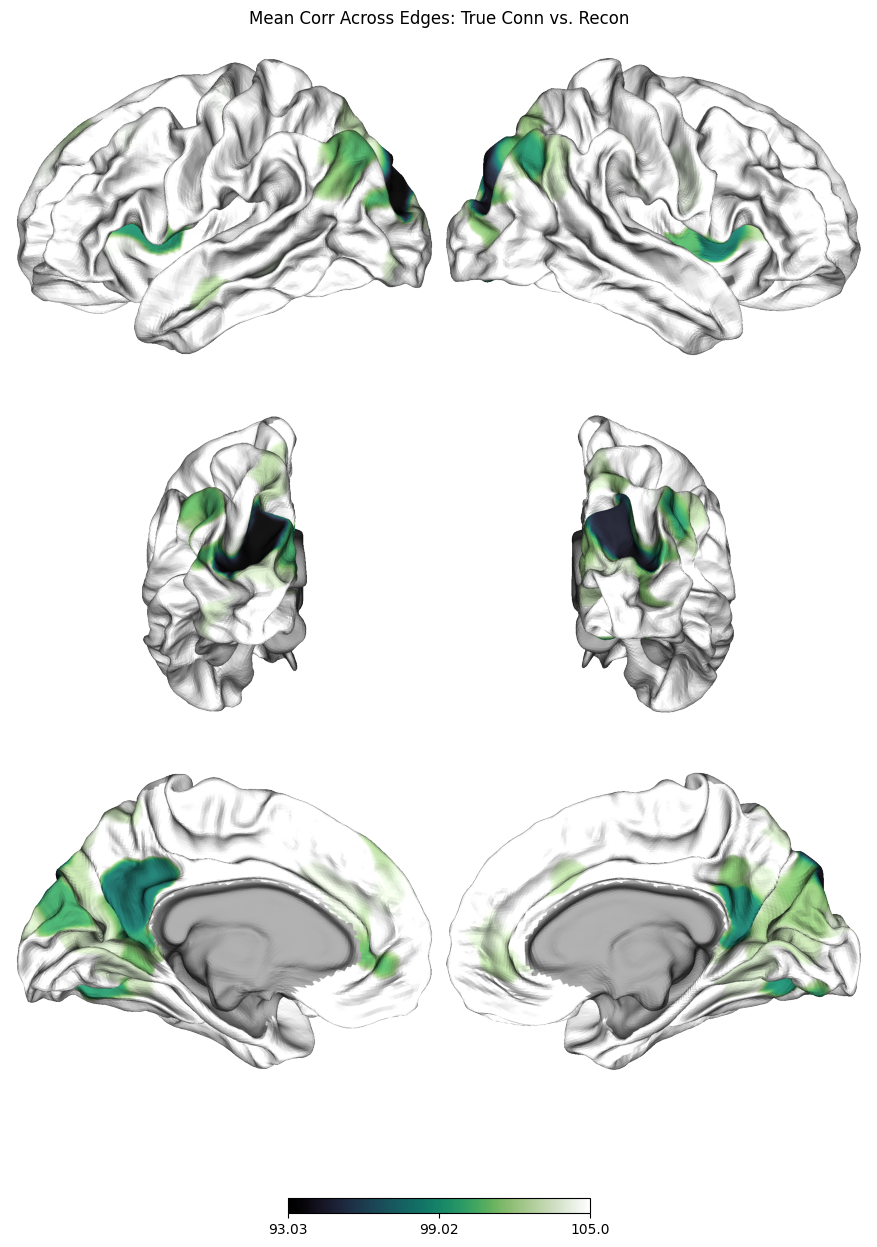

In [66]:
cmap = plt.get_cmap('cmr.swamp')

plot = Plot(lh, rh, size=(1200, 1500), brightness=0.5, views=['lateral', 'posterior', 'medial'])
plot.add_layer({'left': group_mape_mapped.mean(axis=0)[:n_vrtx_hemi],
                'right': group_mape_mapped.mean(axis=0)[n_vrtx_hemi:]},
                     cbar=True, cmap=cmap,
                     color_range=(93.03, 105),
                     zero_transparent=False,
                     alpha=1,

)
# mape_plot.add_layer({'left': NETWORK_LABELS_NUMBERED_SURF[:32492],
#                      'right': NETWORK_LABELS_NUMBERED_SURF[32492:]}, cmap='gray',
#             as_outline=True, cbar=False)
fig = plot.build()
fig.axes[0].set_title('Mean Corr Across Edges: True Conn vs. Recon', pad=-3)


In [48]:
np.load("/Users/VictoriaShevchenko/Documents/contrastive-learning/data/HCP_1029sub_400parcels_Kong2022_gMSHB_FC_all.npy")

array([[[ 1.        ,  0.5946063 ,  0.4015074 , ...,  0.18243706,
          0.26279616,  0.01346764],
        [ 0.5946063 ,  1.        ,  0.4549557 , ...,  0.16270594,
          0.29368114, -0.0255703 ],
        [ 0.4015074 ,  0.4549557 ,  1.        , ..., -0.0257437 ,
          0.16814412, -0.08719708],
        ...,
        [ 0.18243706,  0.16270594, -0.0257437 , ...,  1.        ,
          0.5293573 ,  0.7401111 ],
        [ 0.26279616,  0.29368114,  0.16814412, ...,  0.5293573 ,
          1.        ,  0.318228  ],
        [ 0.01346764, -0.0255703 , -0.08719708, ...,  0.7401111 ,
          0.318228  ,  1.        ]],

       [[ 1.        ,  0.69081455,  0.6274541 , ..., -0.15731084,
         -0.01186504, -0.16972102],
        [ 0.69081455,  1.        ,  0.7801826 , ..., -0.18526657,
         -0.02713386, -0.28289354],
        [ 0.6274541 ,  0.7801826 ,  1.        , ..., -0.1730445 ,
          0.01378876, -0.21850488],
        ...,
        [-0.15731084, -0.18526657, -0.1730445 , ...,  

In [56]:
true_mat_vec = sym_matrix_to_vec(true_mat, discard_diagonal = True)
recon_mat_vec = sym_matrix_to_vec(recon_mat, discard_diagonal = True)

In [60]:
sim_null_dist = []
for i in tqdm(range(10)):
    shuffled_recon = recon_mat_vec.copy()
    np.random.shuffle(shuffled_recon)
    sim = np.diag(cosine_similarity(recon_mat_vec, shuffled_recon)).mean()
    sim_null_dist.append(sim)
sim_null_dist = np.array(sim_null_dist)

100%|█████████████████████████████████████████████████████████████████████| 10/10 [05:53<00:00, 35.32s/it]


In [61]:
sim_null_dist

array([0.6893528 , 0.69074255, 0.6894885 , 0.68904436, 0.69011223,
       0.6886922 , 0.6904257 , 0.6904854 , 0.68943465, 0.69275093],
      dtype=float32)

In [ ]:
np.concatenate(sim_null_dist, np.diag(cosine_similarity(recon_mat_vec, true_mat_vec)).mea)

In [62]:
np.diag(cosine_similarity(recon_mat_vec, true_mat_vec)).mean()

np.float64(0.8782642169059856)